In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform

import matplotlib.pyplot as plt # for plotting
import numpy as np

In [3]:
from Vocab_class import TermVocab

In [4]:
torch.cuda.is_available()

True

In [5]:
X = torch.rand((500,300))
X.is_cuda

False

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'NVIDIA GeForce GTX 1660 Ti with Max-Q Design'

In [7]:
X_gpu = X.to(device)
print(X_gpu)
X_gpu.is_cuda

tensor([[0.5462, 0.0158, 0.8896,  ..., 0.3428, 0.6432, 0.2559],
        [0.2148, 0.6272, 0.5461,  ..., 0.5231, 0.7102, 0.5841],
        [0.8136, 0.9744, 0.7696,  ..., 0.4090, 0.8110, 0.5507],
        ...,
        [0.4330, 0.4355, 0.7279,  ..., 0.0924, 0.4207, 0.0490],
        [0.4576, 0.8898, 0.6093,  ..., 0.1152, 0.0948, 0.0204],
        [0.3093, 0.2104, 0.2920,  ..., 0.8747, 0.8876, 0.4351]],
       device='cuda:0')


True

In [8]:
%%time
for i in range(100):
    X_2 = torch.matmul(X,X.T)

CPU times: user 668 ms, sys: 0 ns, total: 668 ms
Wall time: 87.1 ms


In [9]:
%%time
for i in range(100):
    X_g_2 = torch.matmul(X_gpu, X_gpu.T)

CPU times: user 269 ms, sys: 53 ms, total: 322 ms
Wall time: 343 ms


### Image Transforms

In [126]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        #print('in transform init, rescalling')
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        #print('in transform call')
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        return img


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #print('in transform to tensor call')
        image = image.transpose((2, 0, 1))
        return image


IMAGE_RESIZE = (256, 256)
# Sequentially compose the transforms
img_transform = transforms.Compose([
    Rescale(IMAGE_RESIZE), ToTensor()])


### Captions Preprocessing

In [127]:
class CaptionsPreprocessing:
    """Preprocess the captions, generate vocabulary and convert words to tensor tokens

    Args:
        captions_file_path (string): captions tsv file path
    """
    def __init__(self, captions_file_path):
        self.captions_file_path = captions_file_path

        # Read raw captions
        self.raw_captions_dict = self.read_raw_captions()

        # Preprocess captions
        self.captions_dict = self.process_captions()

        # Create vocabulary
        self.vocab = self.generate_vocabulary()

    def read_raw_captions(self):
        """
        Returns:
            Dictionary with raw captions list keyed by image ids (integers)
        """

        captions_dict = {}
        with open(self.captions_file_path, 'r', encoding='utf-8') as f:
            for img_caption_line in f.readlines():
                img_captions = img_caption_line.strip().split('\t')
                captions_dict[img_captions[0]] = img_captions[1]

        return captions_dict

    def process_captions(self):
        """
        Use this function to generate dictionary and other preprocessing on captions
        """

        raw_captions_dict = self.raw_captions_dict

        # Do the preprocessing here
        captions_dict = raw_captions_dict

        return captions_dict

    def generate_vocabulary(self):
        """
        Use this function to generate dictionary and other preprocessing on captions
        """

        captions_dict = self.captions_dict

        # Generate the vocabulary
        vocab = TermVocab()
        for img_id in captions_dict:
            contents = captions_dict[img_id].split()
            #print('for img-',img_id,":",contents)
            for term in contents:
                vocab.add_term(term)
        print('Generated vocab')
        
        return vocab

    def captions_transform(self, img_caption_list):
        """
        Use this function to generate tensor tokens for the text captions
        Args:
            img_caption_list: List of captions for a particular image
        """
        vocab = self.vocab

        # Generate tensors
        #print("caption transform called, with img caption list:", img_caption_list)
        #print(img_caption_list[0])
        img_cap_terms = img_caption_list.split()
        op = torch.zeros(vocab.vocab_length)
        for term in img_cap_terms:
            op[vocab.to_index(term)] += 1
        #print('caption transform op:', op)
        return op
        # OLD:return torch.zeros(len(img_caption_list), 10)

# Set the captions tsv file path
CAPTIONS_FILE_PATH = '/media/harsh/Common/IITD/COL774-ML/ass4/Train_text.tsv'
captions_preprocessing_obj = CaptionsPreprocessing(CAPTIONS_FILE_PATH)

Generated vocab


In [128]:
captions_preprocessing_obj.captions_dict['train_data/res3.jpg']

'several men in hard hats are'

In [129]:
torch.zeros(5,2)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

### Dataset Class

In [133]:
class ImageCaptionsDataset(Dataset):

    def __init__(self, img_dir, captions_dict, img_transform=None, captions_transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            captions_dict: Dictionary with captions list keyed by image paths (strings)
            img_transform (callable, optional): Optional transform to be applied
                on the image sample.

            captions_transform: (callable, optional): Optional transform to be applied
                on the caption sample (list).
        """
        self.img_dir = img_dir
        self.captions_dict = captions_dict
        self.img_transform = img_transform
        print('img transform',img_transform)
        self.captions_transform = captions_transform

        self.image_ids = list(captions_dict.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        #print('img name', img_name)
        IMAGE_DIR = '/media/harsh/Common/IITD/COL774-ML/ass4/train_data/'
        image = io.imread(IMAGE_DIR+img_name)
        captions = self.captions_dict[img_name]

        if self.img_transform:
            image = self.img_transform(image)

        if self.captions_transform:
            captions = self.captions_transform(captions)

        sample = {'image': image, 'captions': captions}

        return sample

### Model Architecture

In [164]:
class ImageCaptionsNet(nn.Module):
    def __init__(self):
        super(ImageCaptionsNet, self).__init__()
        
        # Define your architecture here
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256*256*3, 512),
            #nn.ReLU(),
            nn.Linear(512,512),
            #nn.ReLU(),
            nn.Linear(512,10)
        )
    
    def forward(self, x):
        x = image_batch, captions_batch
        print(image_batch.shape)
        print('------------------------------------')
        print(captions_batch)
        # Forward Propogation
        x1 = self.flatten(image_batch.float())
        logits = self.linear_relu_stack(x1)
        print('op', logits)
        return captions_batch

net = ImageCaptionsNet()

# If GPU training is required
# net = net.cuda()

### Training Loop

In [165]:
IMAGE_DIR = '/media/harsh/Common/IITD/COL774-ML/ass4/train_data/'
# Creating the Dataset
train_dataset = ImageCaptionsDataset(
    IMAGE_DIR, captions_preprocessing_obj.captions_dict, img_transform=img_transform,
    captions_transform=captions_preprocessing_obj.captions_transform
)

# Define your hyperparameters
NUMBER_OF_EPOCHS = 3
LEARNING_RATE = 1e-1
BATCH_SIZE = 32
NUM_WORKERS = 0 # Parallel threads for dataloading
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

# Creating the DataLoader for batching purposes
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
import os
for epoch in range(NUMBER_OF_EPOCHS):
    for batch_idx, sample in enumerate(train_loader):
        net.zero_grad()

        image_batch, captions_batch = sample['image'], sample['captions']

        # If GPU training required
        # image_batch, captions_batch = image_batch.cuda(), captions_batch.cuda()

        output_captions = net((image_batch, captions_batch))
        print('output size:',output_captions.shape)
        print('real caption size:',captions_batch.shape)
        loss = loss_function(output_captions, captions_batch)
        loss.backward()
        optimizer.step()
    print("Iteration: " + str(epoch + 1))

img transform Compose(
)
torch.Size([32, 3, 256, 256])
------------------------------------
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
op tensor([[-0.0176,  0.1295, -0.1330, -0.0300,  0.0774, -0.0298, -0.1137,  0.0749,
          0.0552,  0.0605],
        [-0.0252,  0.1282, -0.0364,  0.0370,  0.0509, -0.0389, -0.0629,  0.0177,
          0.0609,  0.0608],
        [-0.0493,  0.1094, -0.0923, -0.0396,  0.0208, -0.0682, -0.0224,  0.0426,
          0.0590, -0.0087],
        [-0.0777,  0.1145, -0.1475, -0.0069,  0.0154,  0.0256, -0.0913,  0.0014,
          0.0049, -0.0745],
        [-0.0631,  0.2200, -0.1969,  0.0344,  0.1058, -0.0546, -0.0472, -0.0670,
          0.0398,  0.0580],
        [-0.0339,  0.0590, -0.1814,  0.0455,  0.0111, -0.0366, -0.0945,  0.0974,
          0.0378,  0.0354

RuntimeError: 1D target tensor expected, multi-target not supported

In [163]:
loss_function(torch.tensor([1,0,1]), torch.tensor([0,0,0]))

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
temp_img = io.imread(IMAGE_DIR+'train_data/res39376.jpg')

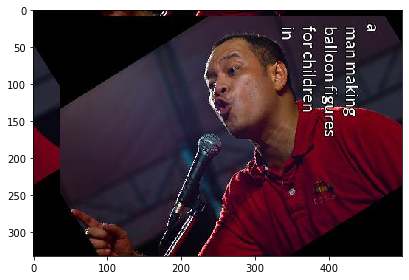

In [88]:
io.imshow(temp_img)

in transform call
in transform to tensor call


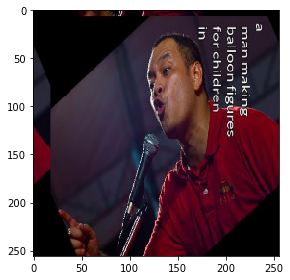

In [95]:
io.imshow(img_transform(temp_img).transpose(1,2,0))